![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2FApplied+Forecasting&dt=Vertex+AI+Pipelines+-+BQML+ARIMA%2B.ipynb)

# Vertex AI Pipelines - BQML ARIMA+

In the [BQML Univariate Forecasting with ARIMA+](./BQML%20Univariate%20Forecasting%20with%20ARIMA+.ipynb) notebook, BigQuery ML was used to fit a forecasting model to citibike bike rentals daily volume data prepared in the [BigQuery Time Series Forecasting Data Review and Preparation](./BigQuery%20Time%20Series%20Forecasting%20Data%20Review%20and%20Preparation.ipynb).

This notebook uses a [Vertex AI Pipeline](https://cloud.google.com/vertex-ai/docs/pipelines/introduction) that is pre-built to handle the code behind building the forecasting model and retrieving predictions from it.  This pre-built pipeline also does many more steps with data validation and even backtesting the forecasting and calculating associated metrics.  

This still uses BigQuery but orchestrates the steps with a pipeline built with the [Kubeflow Pipelines SDK](https://www.kubeflow.org/docs/components/pipelines/v2/introduction/) and runs in the managed environment of Vertex AI Pipelines.  Pipeline steps run in components which run associated code in a related container.  While these components can be custom built by the user, in this case, the pipeline is completely [pre-built](https://cloud.google.com/vertex-ai/docs/pipelines/components-introduction) so only inputs to functions are needed to drive the pipeline execution. 

---

**Series Overview**

[This series](./readme.md) explores forecasting with Vertex AI, BigQuery ML, and additional open source frameworks.  Forecasting consist of following a measurement over time and exploring trends, the impact of seasonality (years, months, days, etc), holidays, and special events with the hope of using these insights to forecast into the near future.  Some method also incoporate observable measurements that impact demand to understand the relationships and make forecasting more accurate.

**Data Source: Citibike rentals in New York City**

This series uses Citibike rentals in New York city.  The bike stations near central park will be selected and the daily number bike trips that orignate from these stations will be followed over time.  This will illustrate some common forecasting issues due to new stations being introduced over time and some stations only have the most recent few months, or just weeks of data.  The data are found in the BigQuery Public datasets at:: 
- `bigquery-public-data.new_york.citibike_trips`
- `bigquery-public-data.new_york.citibike_stations`

**BigQuery ML (BQML) Overview**

[BigQuery ML](https://cloud.google.com/bigquery/docs/bqml-introduction) allows you to use `SQL` to constuct an ML workflow.  This is a great leap in productivity and flexibility when the data source is [BigQuery](https://cloud.google.com/bigquery/docs/introduction) and users are already familiar with `SQL`. Using just `SQL`, [multiple techniques](https://cloud.google.com/bigquery/docs/bqml-introduction#model_selection_guide) can be used for model training and even include [hyperparameter tuning](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-hp-tuning-overview).  It includes serverless [training, evaluation, and inference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey) techniques for supervised, unsupervised, time series methods, even recommendation engines.  [Predictions](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-inference-overview) can be served directly in BigQuery which also include explainability measures. Predictive models can be [exported to their native framework](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-export-model) for portability, or even directly [registered to Vertex AI model registry](https://cloud.google.com/bigquery/docs/managing-models-vertex) for online predictions on Vertex AI Endpoints.  You can [import models into BigQuery ML](https://cloud.google.com/bigquery/docs/reference/standard-sql/inference-overview#inference_using_imported_models) from many common framework, or [connect to remotely hosted models](https://cloud.google.com/bigquery/docs/reference/standard-sql/inference-overview#inference_using_remote_models) on Vertex AI Endpoints. You can even directly use many [pre-trained models](https://cloud.google.com/bigquery/docs/reference/standard-sql/inference-overview#pretrained-models) in Vertex AI Like Cloud Vision API, Cloud Natural Language API, and Cloud Translate API.

A great starting point for seeing the scope of available methods is the [user journey for models](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey).  This repository also has a series of notebook based workflows for many BigQuery ML methods that can be reviewed here: [../03 - BigQuery ML (BQML)](../03%20-%20BigQuery%20ML%20(BQML)/readme.md).

---

**Prerequisites:**
- [BigQuery Time Series Forecasting Data Review and Preparation](./BigQuery%20Time%20Series%20Forecasting%20Data%20Review%20and%20Preparation.ipynb)
    - prepare data for this notebook

**Resources**
- [BigQuery](https://cloud.google.com/bigquery/docs/introduction)
    - [BigQuery Python Client](https://cloud.google.com/python/docs/reference/bigquery/latest)
    - [BigQuery ML](https://cloud.google.com/python/docs/reference/bigquery/latest)
    - [SQL Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax)
    - [BigQuery ML SQL Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-time-series)
- [Vertex AI](https://cloud.google.com/vertex-ai/docs/start/introduction-unified-platform)
    - [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction)
    - [Vertex AI Python SDK](https://cloud.google.com/python/docs/reference/aiplatform/latest)
    - [Vertex AI Forecasting Pipelines BQML ARIMA+](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting-arima/overview)
    - Google Cloud Pipeline Components (pre-built):
        - [Documentation](https://cloud.google.com/vertex-ai/docs/pipelines/components-introduction)
        - [SDK Reference](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-1.0.41/)

---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/Vertex%20AI%20Pipelines%20-%20BQML%20ARIMA+.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Setup

### Package Installs

This notebook uses [Google Cloud Pipeline Components](https://cloud.google.com/vertex-ai/docs/pipelines/components-introduction) that are pre-built.  In order to use these install 

In [3]:
try:
    import google_cloud_pipeline_components
except ImportError:
    !pip install google-cloud-pipeline-components -q

### Environment

inputs:

In [4]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [5]:
REGION = 'us-central1'
EXPERIMENT = 'pipeline-bqml-arimaplus'
SERIES = 'applied-forecasting'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = 'forecasting-data_prepped'

viz_limit = 12

packages:

In [6]:
from google.cloud import bigquery
from google.cloud import aiplatform
from google_cloud_pipeline_components.experimental.automl.forecasting import utils

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

clients:

In [7]:
bq = bigquery.Client(project = PROJECT_ID)
aiplatform.init(project=PROJECT_ID, location=REGION)

parameters:

In [8]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

In [9]:
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'1026793852137-compute@developer.gserviceaccount.com'

---
## Review Time Series

**Univariate Forecasting** consists of just 2 columns per time series:
- `TARGET_COLUMN` = The demand measurment.
    In our case it is the number of trips taken per day from a particular bike station - the sum of trips for a day.
- `TIME_COLUMN` = The time of demand.
    Expressed in the time or date units related to the granularity of the forecast exercise.  In our case, demand is measured daily so the time column is prepared as a date. 

**Additional Columns** are used to instruct the forecasting algorithms handling of the data:
- `SERIES_COLUMN` groups rows associated with the same time series.
    - Conducting multiple forecasts, one per time series, means including a third column to capture the groups of row for each time series: `SERIES_COLUMN`. 
    - **NOTE:** BigQuery ARIMA+ fits a separate forecast for each of these groups.  In our case this is the `start_station_name` which is the name for each individual Citibike station near Central Park.
- `SPLITS_COLUMN` groups sequential rows within each time series for their purpose during the forecasting exercsie.
    - This data was prepared with splits for `TRAIN`, `VALIDATE` and `TEST` in the prerequisite notebooks.  The column that contains these splits can be used by the choosen forecast method during training rather than have the method calculate the splits.  This can be helpful when comparing multiple different methods as it ensures splitting is handled the same across each method.
    
**Forecasting Parameters**:
- `FORECAST_GRANULARITY` is the frequency of measurment like MINUTE, HOUR, DAY, WEEK, MONTH, YEAR
    - The data was summarized at the DAY level in the data preparation notebook
    - This is the amount of time between measurments - rows 
    - For a different granularity, you may need to summarize the demand signal as a `SUM`, `MIN`, `MAX`, or `AVERAGE` for different time components.
    - specification of granularity differs by method:
        - BigQuery ML: PER_MINUTE, HOURLY, DAILY, WEEKLY, MONTHLY, QUARTERLY, YEARLY
        - Prophet (including Vertex Pre-Built Pipelines): minute, hour, day, week, month, or year
        - Vertex AI AutoML: minute, hour, day, week, month, year 
    - A very helpful BigQuery function for extracting components of times and dates is the `EXTRACT` function:
        - [EXTRACT as a date function](https://cloud.google.com/bigquery/docs/reference/standard-sql/date_functions#extract)
        - [EXTRACT as a time function](https://cloud.google.com/bigquery/docs/reference/standard-sql/time_functions#extract)
        - [EXTRACT as a datetime function](https://cloud.google.com/bigquery/docs/reference/standard-sql/datetime_functions#extract).
- `FORECAST_TEST_LENGTH` is the number of rows allocated to the test region
    - This is in the units of `FORECAST_GRANULARITY`.
    - The data preparation included setting this for specifying the `SPLITS_COLUMN = 'TEST'` values for each time series in `SERIES_COLUMMN`.
- `FORCAST_VALIDATE_LENGTH` is the number of rows allocated to the validation region
    - This is in the units of `FORECAST_GRANULARITY`.
    - The data preparation included setting this for specifying the `SPLITS_COLUMN = 'VALIDATE'` values for each time series in `SERIES_COLUMN`.
- `FORECAST_HORIZON_LENGTH` is the number of rows to forecast into the future beyond the test region
    - This is in the units of `FORECAST_GRANULARITY`
    - This needs to be set as an input to the forecast method

In [10]:
# CUSTOMIZE
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'
SPLIT_COLUMN = 'splits'

# CUSTOMIZE
FORECAST_GRANULARITY = 'DAY' # the data preparation included preparing the data at this level
FORECAST_HORIZON_LENGTH = 14
FORECAST_TEST_LENGTH = 14 # the data preparation included setting this value for splits = TEST
FORECAST_VALIDATE_LENGTH = 14 # the data preparation included setting this value for splits = VALIDATE

Retrieve Key Dates from splits.  The splits were defined when the data was processed by the prerequisite notebook.  This will retrieve information from the prepared data:

In [11]:
query = f"""
    WITH
        SPLIT AS (
            SELECT {SPLIT_COLUMN}, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            GROUP BY splits
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE {SPLIT_COLUMN} ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE {SPLIT_COLUMN} = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE {SPLIT_COLUMN} = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq.query(query).to_dataframe()
keyDates

start_date   val_start  test_start    end_date
0  2013-07-01  2016-09-03  2016-09-17  2016-09-30

Correct the set values of `FORECAST_TEST_LENGTH` and `FORECAST_VALIDATE_LENGTH` to match the prepared data:

In [12]:
if FORECAST_TEST_LENGTH != (keyDates['end_date'][0] - keyDates['test_start'][0]).days + 1:
    FORECAST_TEST_LENGTH = (keyDates['end_date'][0] - keyDates['test_start'][0]).days + 1
    
if FORECAST_VALIDATE_LENGTH != (keyDates['test_start'][0] - keyDates['val_start'][0]).days:
    FORECAST_VALIDATE_LENGTH = (keyDates['test_start'][0] - keyDates['val_start'][0]).days
    
print('FORECAST_TEST_LENGTH is ', FORECAST_TEST_LENGTH)
print('FORECAST_VALIDATE_LENGTH is ', FORECAST_VALIDATE_LENGTH)

FORECAST_TEST_LENGTH is  14
FORECAST_VALIDATE_LENGTH is  14


Retrieve raw data:

In [13]:
query = f"""
    SELECT {SERIES_COLUMN}, {TIME_COLUMN}, {SPLIT_COLUMN}, {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq.query(query).to_dataframe()

### Plot Time Series

Create an interactive chart for review individual time series (bike stations) and scrolling through the time range by using [Plotly](https://plotly.com/python/):

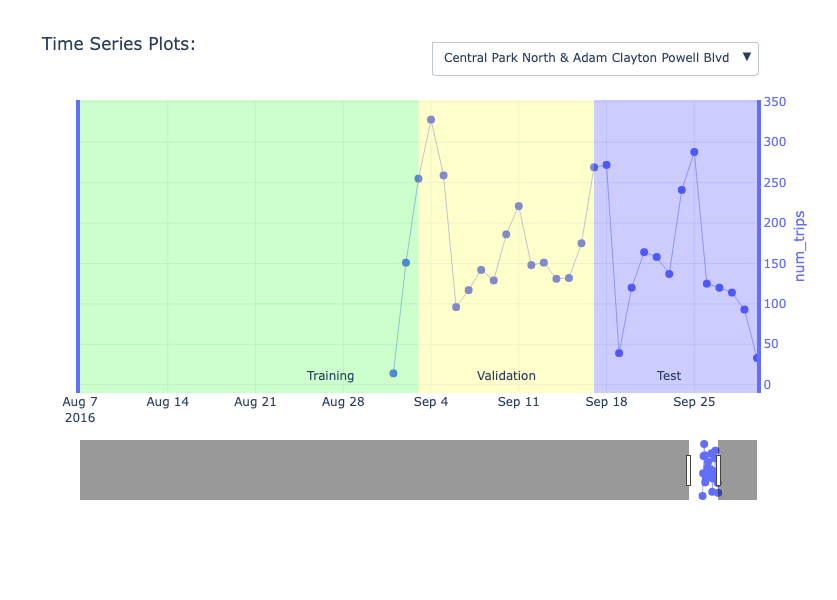

In [14]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] # + COVARIATE_COLUMNS # no covariate for univarate forecasting

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
    
    # which button to show:
    ff = 0 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()

A Snapshot of the interactive plot:


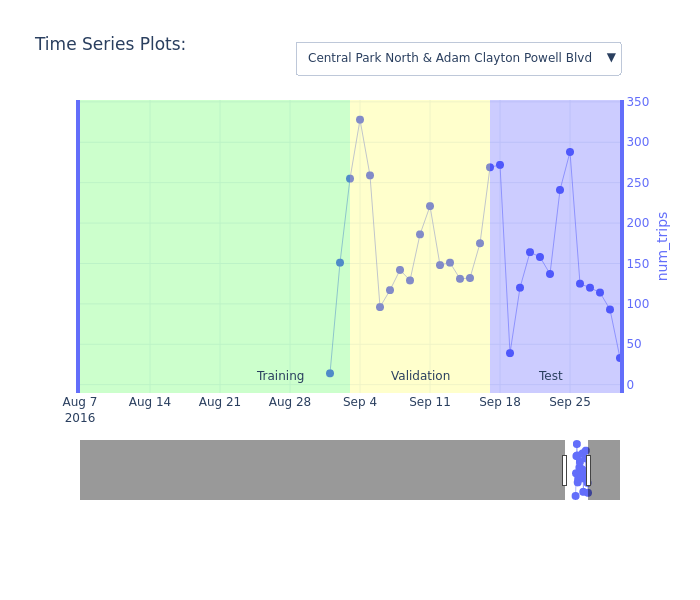

In [15]:
print('A Snapshot of the interactive plot:')
fig.show('png')

---
## Create Forecast Model
Use BigQuery ML Arima+ (`model_type = 'ARIMA_PLUS'`), a feature of [BigQuery ML](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey).  This does univariate time series modeling using ARIMA while also automating many of the task of this type of inference: preprocessing, holiday adjustments, spikes, dips, outlier, seasonal & trend decomposition, step change adjustment, trend modeling, forecasting.  A representation of this pipeline from the BigQuery ML documentation:

<p><center>
    <img alt="ARIMA_PLUS Flowchart" src="https://cloud.google.com/static/bigquery/images/BQ_ARIMA_diagram.png" width="75%">
</center><p>

### Training Pipeline

#### Create the Training Pipeline Specifications

Rather than directly interacting with BigQuery as was done in the [BQML Univariate Forecasting with ARIMA+](./BQML%20Univariate%20Forecasting%20with%20ARIMA+.ipynb) notebook, this example uses a pre-built pipeline running on Vertex AI Pipelines.  This means just providing parameters and letting it do the coding work on our behalf.  It actually does much more though.  It also does back testing of the forecasting algorithm in specified windows.  

Link to SDK for [utils.get_bqml_arima_train_pipeline_and_parameters](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-1.0.41/google_cloud_pipeline_components.experimental.automl.forecasting.html#google_cloud_pipeline_components.experimental.automl.forecasting.utils.get_bqml_arima_train_pipeline_and_parameters)

In [16]:
train_job_spec_path, train_parameter_values = utils.get_bqml_arima_train_pipeline_and_parameters(
    root_dir = f'gs://{PROJECT_ID}/{SERIES}/{EXPERIMENT}',
    project = PROJECT_ID,
    location = REGION,
    time_column = TIME_COLUMN,
    time_series_identifier_column = SERIES_COLUMN,
    target_column = TARGET_COLUMN,
    forecast_horizon = FORECAST_HORIZON_LENGTH,
    data_granularity_unit = FORECAST_GRANULARITY,
    predefined_split_key = SPLIT_COLUMN,
    data_source_bigquery_table_path = f'bq://{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}',
    window_stride_length = 1,
    bigquery_destination_uri = f"{BQ_PROJECT}.{BQ_DATASET}_{EXPERIMENT.replace('-','_')}",
    override_destination = True,
    max_order = 5,
)

#### Run The Training Pipeline

Link to SDK for [aiplatform.PipelineJob()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.PipelineJob)

In [17]:
training_pipeline_job = aiplatform.PipelineJob(
    job_id = f'{SERIES}-{EXPERIMENT}-{TIMESTAMP}',
    display_name = f'{SERIES}-{EXPERIMENT}-{TIMESTAMP}',
    pipeline_root = f'gs://{PROJECT_ID}/{SERIES}/{EXPERIMENT}/pipeline_root',
    template_path = train_job_spec_path,
    parameter_values = train_parameter_values
)

Link to SDK for:
- [aiplatform.PipelineJob.submit()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.PipelineJob#google_cloud_aiplatform_PipelineJob_submit)
    - Runs and does not wait
- [aiplatform.PipelineJob.run()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.PipelineJob#google_cloud_aiplatform_PipelineJob_run)
    - Runs and waits will reporing progress in the log

In [18]:
training_pipeline_job.submit(
    service_account=SERVICE_ACCOUNT
)

Creating PipelineJob
PipelineJob created. Resource name: projects/1026793852137/locations/us-central1/pipelineJobs/applied-forecasting-pipeline-bqml-arimaplus-20230403001148
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/1026793852137/locations/us-central1/pipelineJobs/applied-forecasting-pipeline-bqml-arimaplus-20230403001148')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/applied-forecasting-pipeline-bqml-arimaplus-20230403001148?project=1026793852137


In [19]:
print(f'The Dashboard can be viewed here:\n{training_pipeline_job._dashboard_uri()}')

The Dashboard can be viewed here:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/applied-forecasting-pipeline-bqml-arimaplus-20230403001148?project=1026793852137


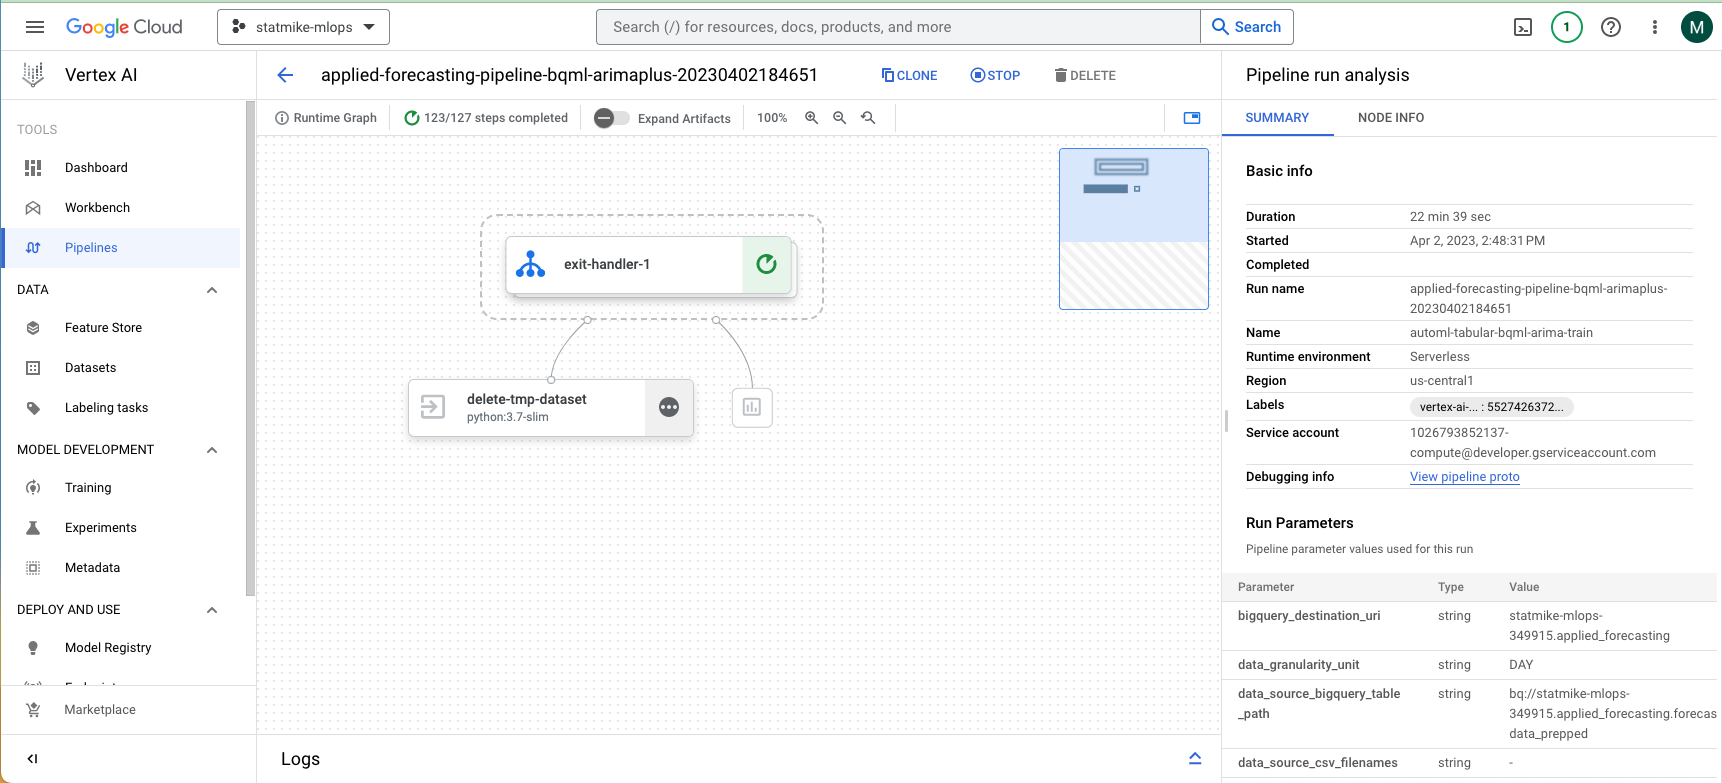

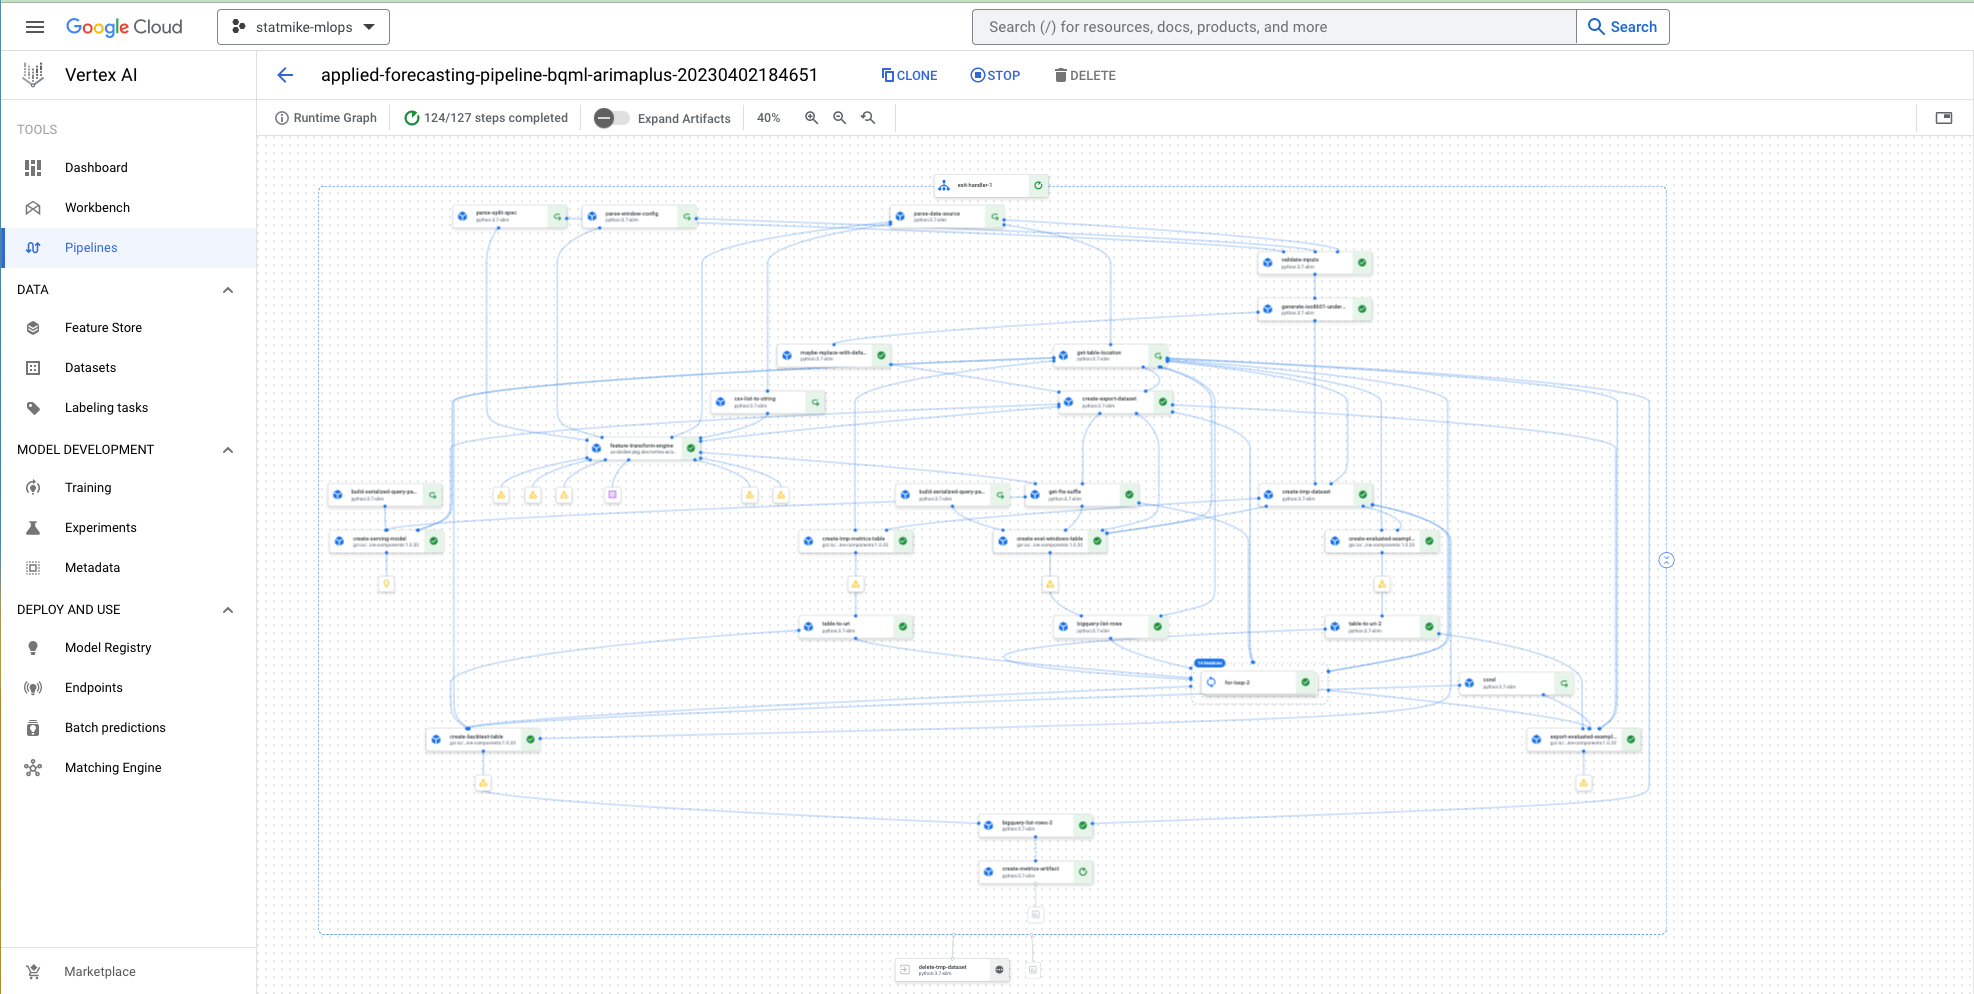

#### Wait On Training Pipeline Job

In [20]:
training_pipeline_job.wait()

PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/applied-forecasting-pipeline-bqml-arimaplus-20230403001148 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/applied-forecasting-pipeline-bqml-arimaplus-20230403001148 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/applied-forecasting-pipeline-bqml-arimaplus-20230403001148 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/applied-forecasting-pipeline-bqml-arimaplus-20230403001148 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/applied-forecasting-pipeline-bqml-arimaplus-20230403001148 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/applied-forecasting-pipel

#### Review Training Pipeline Job

In [21]:
aiplatform.get_pipeline_df(pipeline = f'automl-tabular-bqml-arima-train').head(1)

pipeline_name  \
0  automl-tabular-bqml-arima-train   

                                            run_name  \
0  applied-forecasting-pipeline-bqml-arimaplus-20...   

  param.input:predefined_split_key param.input:forecast_horizon  \
0                           splits                           14   

                                param.input:root_dir  \
0  gs://statmike-mlops-349915/applied-forecasting...   

  param.input:timestamp_split_key param.input:max_order  \
0                               -                     5   

  param.input:window_max_count  \
0                           -1   

                param.input:bigquery_destination_uri param.input:location  \
0  statmike-mlops-349915.applied_forecasting_pipe...          us-central1   

   ...  param.input:data_source_csv_filenames param.input:validation_fraction  \
0  ...                                      -                            -1.0   

  param.input:window_column param.input:data_granularity_unit  \
0                         -                               DAY   

  param.input:test_fraction  \
0                      -1.0   

         param.input:data_source_bigquery_table_path  \
0  bq://statmike-mlops-349915.applied_forecasting...   

  param.input:target_column  metric.rootMeanSquaredError  \
0                 num_trips             55.3558691846862   

  metric.meanAbsolutePercentageError metric.meanAbsoluteError  
0                  70.43842830647665        38.36547893644233  

[1 rows x 26 columns]

#### Get The BQML Model
Just like working directly with BigQuery, this pipeline also creates a model in BigQuery than can be retrieved and reviewed - even in the console.

In [22]:
for task in training_pipeline_job.gca_resource.job_detail.task_details:
    if task.task_name == "bigquery-create-model-job":
        model_name = task.outputs["model"].artifacts[0].metadata["modelId"]
        break
else:
    raise ValueError("Not Found.")
    
print(model_name)

model_5763407406092517376


Directly retrieve the feature info for the model using the BigQuery client:

In [23]:
query = f"""
    SELECT *
    FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}_{EXPERIMENT.replace('-','_')}.{model_name}`)
"""
featureInfo = bq.query(query).to_dataframe()
featureInfo.head()

input  min    max        mean  median     stddev  \
0           num_trips  1.0  607.0  119.971702   103.0  88.469936   
1           starttime  NaN    NaN         NaN     NaN        NaN   
2  start_station_name  NaN    NaN         NaN     NaN        NaN   

   category_count  null_count  dimension  
0            <NA>           0       <NA>  
1            1184           0       <NA>  
2              12           0       <NA>

### Prediction Pipeline

#### Create the Prediction Pipeline Specifications

Link to SDK for [utils.get_bqml_arima_predict_pipeline_and_parameters](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-1.0.41/google_cloud_pipeline_components.experimental.automl.forecasting.html#google_cloud_pipeline_components.experimental.automl.forecasting.utils.get_bqml_arima_predict_pipeline_and_parameters)

In [24]:
predict_job_spec_path, predict_parameter_values = utils.get_bqml_arima_predict_pipeline_and_parameters(
    project = PROJECT_ID,
    location = REGION,
    model_name = f"{BQ_DATASET}_{EXPERIMENT.replace('-','_')}.{model_name}",
    data_source_bigquery_table_path = f'bq://{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}',
    bigquery_destination_uri = f"{BQ_PROJECT}.{BQ_DATASET}_{EXPERIMENT.replace('-','_')}"
)

#### Run The Prediction Pipeline

Link to SDK for [aiplatform.PipelineJob()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.PipelineJob)

In [25]:
prediction_pipeline_job = aiplatform.PipelineJob(
    job_id = f'prediction-{SERIES}-{EXPERIMENT}-{TIMESTAMP}',
    display_name = f'prediction-{SERIES}-{EXPERIMENT}-{TIMESTAMP}',
    pipeline_root = f'gs://{PROJECT_ID}/{SERIES}/{EXPERIMENT}/pipeline_root/prediction',
    template_path = predict_job_spec_path,
    parameter_values = predict_parameter_values
)

Link to SDK for:
- [aiplatform.PipelineJob.submit()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.PipelineJob#google_cloud_aiplatform_PipelineJob_submit)
    - Runs and does not wait
- [aiplatform.PipelineJob.run()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.PipelineJob#google_cloud_aiplatform_PipelineJob_run)
    - Runs and waits will reporing progress in the log

In [26]:
prediction_pipeline_job.submit(
    service_account=SERVICE_ACCOUNT
)

Creating PipelineJob
PipelineJob created. Resource name: projects/1026793852137/locations/us-central1/pipelineJobs/prediction-applied-forecasting-pipeline-bqml-arimaplus-20230403001148
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/1026793852137/locations/us-central1/pipelineJobs/prediction-applied-forecasting-pipeline-bqml-arimaplus-20230403001148')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/prediction-applied-forecasting-pipeline-bqml-arimaplus-20230403001148?project=1026793852137


In [27]:
print(f'The Dashboard can be viewed here:\n{prediction_pipeline_job._dashboard_uri()}')

The Dashboard can be viewed here:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/prediction-applied-forecasting-pipeline-bqml-arimaplus-20230403001148?project=1026793852137


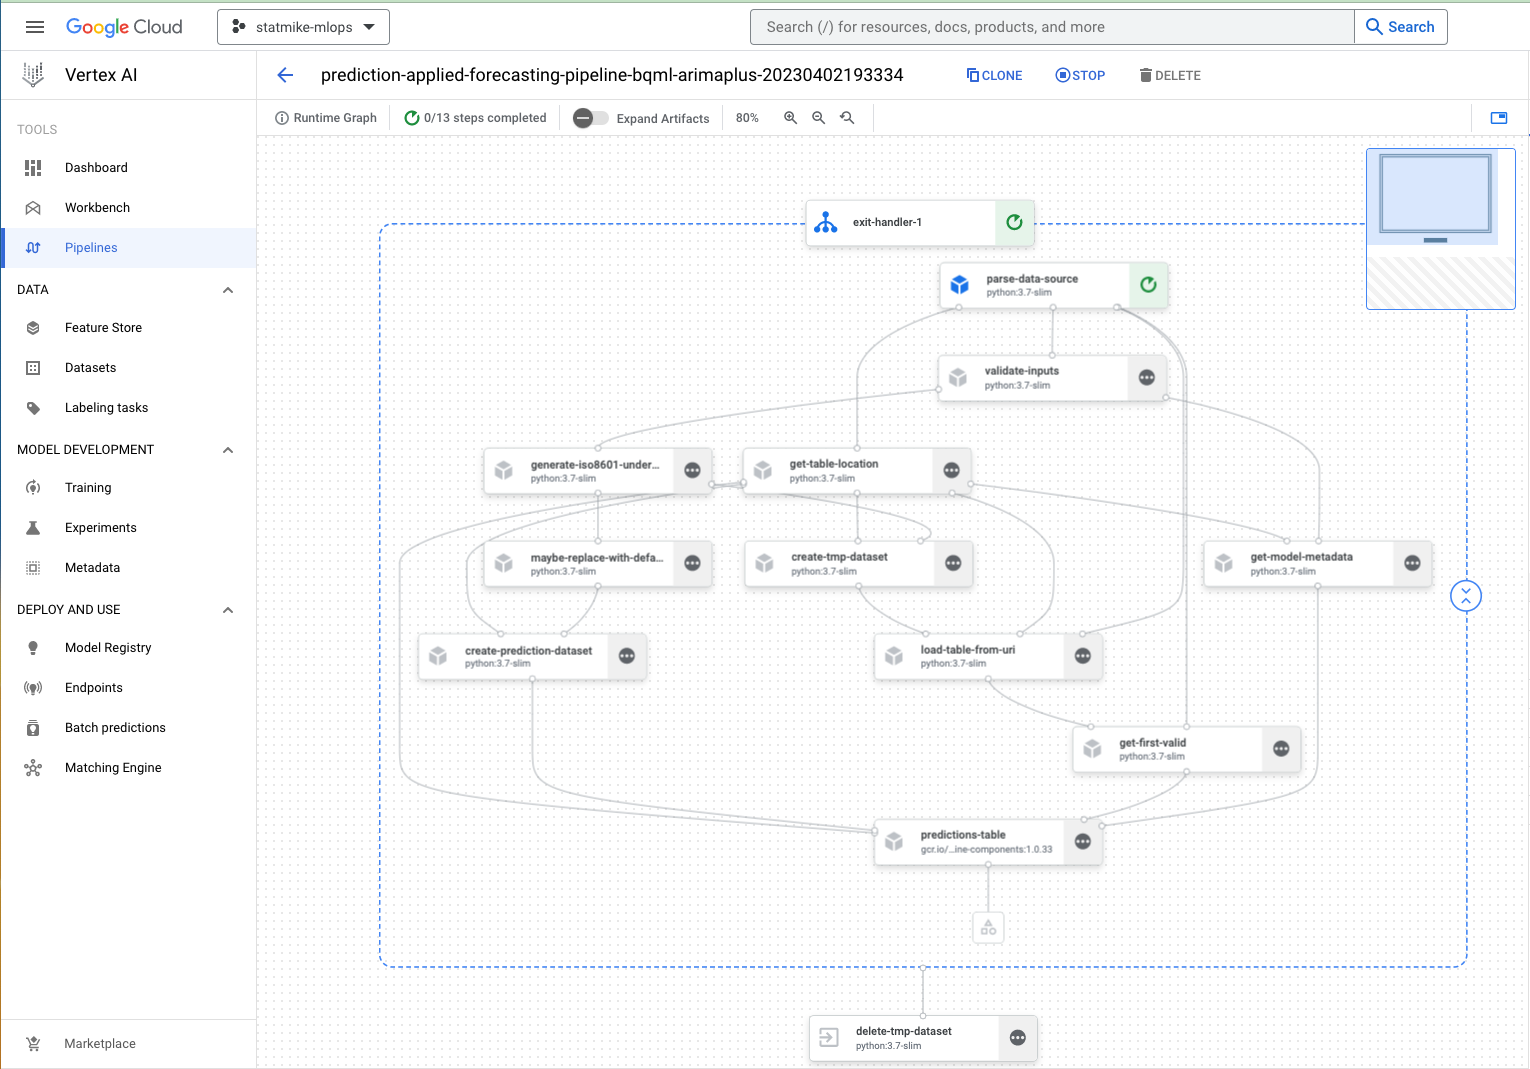

#### Wait On Prediction Pipeline Job

In [28]:
prediction_pipeline_job.wait()

PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/prediction-applied-forecasting-pipeline-bqml-arimaplus-20230403001148 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/prediction-applied-forecasting-pipeline-bqml-arimaplus-20230403001148 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/prediction-applied-forecasting-pipeline-bqml-arimaplus-20230403001148 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/prediction-applied-forecasting-pipeline-bqml-arimaplus-20230403001148 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/prediction-applied-forecasting-pipeline-bqml-arimaplus-20230403001148 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob run completed. Resource name

#### Review Prediction Pipeline Job

In [29]:
aiplatform.get_pipeline_df(pipeline = f'automl-tabular-bqml-arima-prediction').head(1)

pipeline_name  \
0  automl-tabular-bqml-arima-prediction   

                                            run_name  \
0  prediction-applied-forecasting-pipeline-bqml-a...   

         param.input:data_source_bigquery_table_path  \
0  bq://statmike-mlops-349915.applied_forecasting...   

  param.input:data_source_csv_filenames    param.input:project  \
0                                     -  statmike-mlops-349915   

  param.input:location               param.input:bigquery_destination_uri  \
0          us-central1  statmike-mlops-349915.applied_forecasting_pipe...   

                              param.input:model_name  \
0  applied_forecasting_pipeline_bqml_arimaplus.mo...   

  param.input:generate_explanation  
0                            false

#### Get The Table Name

In [30]:
for task in prediction_pipeline_job.gca_resource.job_detail.task_details:
    if task.task_name == "bigquery-query-job":
        pred_table = (
            task.outputs["destination_table"].artifacts[0].metadata["tableId"]
        )
        break
else:
    raise ValueError("Not Found.")
    
pred_table

'predictions_3431668699021443072'

#### Get The Forecasts

In [31]:
query = f"""
    SELECT *, 
        EXTRACT(DATE FROM time_series_timestamp) AS {TIME_COLUMN}
    FROM ML.EXPLAIN_FORECAST(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}_{EXPERIMENT.replace('-','_')}.{model_name}`,
        STRUCT({FORECAST_HORIZON_LENGTH} AS horizon, 0.95 AS confidence_level))
    ORDER BY {SERIES_COLUMN}, {TIME_COLUMN}
"""
explain = bq.query(query).to_dataframe()

In [32]:
explain.head()

start_station_name     time_series_timestamp  \
0  Central Park North & Adam Clayton Powell Blvd 2016-09-01 00:00:00+00:00   
1  Central Park North & Adam Clayton Powell Blvd 2016-09-02 00:00:00+00:00   
2  Central Park North & Adam Clayton Powell Blvd 2016-09-03 00:00:00+00:00   
3  Central Park North & Adam Clayton Powell Blvd 2016-09-04 00:00:00+00:00   
4  Central Park North & Adam Clayton Powell Blvd 2016-09-05 00:00:00+00:00   

  time_series_type  time_series_data  time_series_adjusted_data  \
0          history              14.0                  14.000000   
1          history             151.0                 100.515293   
2          history             255.0                 256.553957   
3          history             328.0                 268.022555   
4          history             259.0                 185.982751   

   standard_error  confidence_level  prediction_interval_lower_bound  \
0       37.832991               NaN                              NaN   
1       37.832991               NaN                              NaN   
2       37.832991               NaN                              NaN   
3       37.832991               NaN                              NaN   
4       37.832991               NaN                              NaN   

   prediction_interval_upper_bound       trend  seasonal_period_yearly  \
0                              NaN  159.745870                     NaN   
1                              NaN  122.779187                     NaN   
2                              NaN  189.116074                     NaN   
3                              NaN  158.772379                     NaN   
4                              NaN  198.401623                     NaN   

   seasonal_period_quarterly  seasonal_period_monthly  seasonal_period_weekly  \
0                        NaN                      NaN              -65.231036   
1                        NaN                      NaN              -22.263894   
2                        NaN                      NaN               67.437883   
3                        NaN                      NaN              109.250176   
4                        NaN                      NaN              -12.418873   

   seasonal_period_daily  holiday_effect  spikes_and_dips  step_changes  \
0                    NaN             NaN              NaN           NaN   
1                    NaN             NaN              NaN           NaN   
2                    NaN             NaN              NaN           NaN   
3                    NaN             NaN              NaN           NaN   
4                    NaN             NaN              NaN           NaN   

    starttime  
0  2016-09-01  
1  2016-09-02  
2  2016-09-03  
3  2016-09-04  
4  2016-09-05

## Visualize Time Series With Forecast

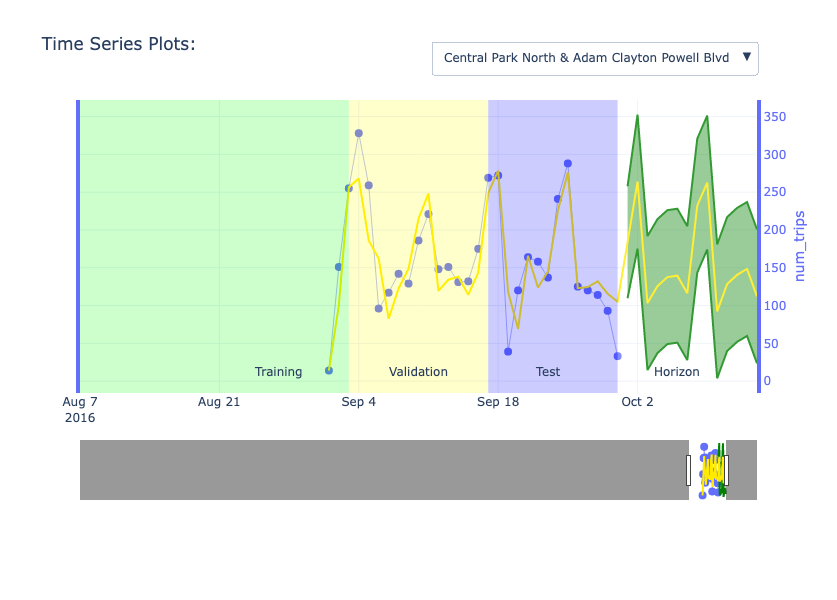

In [33]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] # + COVARIATE_COLUMNS # no covariate for univarate forecasting

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:    
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
        if y == 0: # add the forecast
            # add the forecast prediction funnel to test and horizon: lower
            fig.add_trace(
                go.Scatter(
                    x = explain[explain[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = explain[explain[SERIES_COLUMN]==s]['prediction_interval_lower_bound'],
                    name = f'Lower Prediction: {v}',
                    text = explain[explain[SERIES_COLUMN]==s]['prediction_interval_lower_bound'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(0,128,0)'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
            # add the forecast prediction funnel to test and horizon: upper
            fig.add_trace(
                go.Scatter(
                    x = explain[explain[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = explain[explain[SERIES_COLUMN]==s]['prediction_interval_upper_bound'],
                    name = f'Upper Prediction: {v}',
                    text = explain[explain[SERIES_COLUMN]==s]['prediction_interval_upper_bound'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(0,128,0)'},
                    mode = 'lines',
                    fillcolor = 'rgba(0,128,0,0.5)',
                    fill = 'tonexty',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
            # add the forecast fit
            fig.add_trace(
                go.Scatter(
                    x = explain[explain[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = explain[explain[SERIES_COLUMN]==s]['time_series_adjusted_data'],
                    name = f'Forecast: {v}',
                    text = explain[explain[SERIES_COLUMN]==s]['time_series_adjusted_data'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(255,234,0)'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
    
    # which button to show:
    ff = 3 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# add split regions: horizon
fig.add_shape(
    fillcolor = 'rgba(255, 255, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['end_date'][0],
    x1 = keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH),
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['end_date'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Horizon',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()

A Snapshot of the interactive plot:


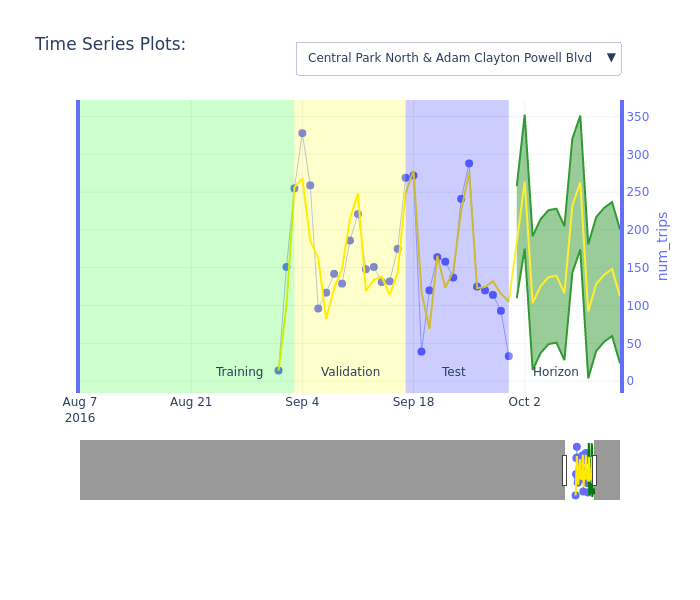

In [34]:
print('A Snapshot of the interactive plot:')
fig.show('png')

## Using SQL to Calculate Metrics

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divided by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$
- MSE, or Mean Squared Error
    - $\textrm{MSE} = \frac{1}{n}\sum{(actual-forecast)^2}$
- RMSE, or Root Mean Squared Error
    - $\textrm{RMSE} = \sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}$
- RMSE divided by average demand so it yeilds a % like MAPE
    - $\textrm{pRMSE} = \frac{\sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}}{\frac{1}{n}\sum{actual}}$

It can be helpful to explicity calculate these to make comparison between datasets and models fair.  This section demonstration these calculation with SQL.

>```sql
>(actual_value - forecast_value) as diff
>
>
>AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
>AVG(ABS(diff)) as MAE,
>SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
>AVG(POW(diff, 2)) as MSE,
>SQRT(AVG(POW(diff, 2))) as RMSE,
>SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
>```


In [35]:
query = f"""
    WITH
        FORECAST AS (
            SELECT
                {SERIES_COLUMN}, 
                EXTRACT(DATE from time_series_timestamp) as {TIME_COLUMN},
                time_series_adjusted_data as forecast_value,
                time_series_type
            FROM ML.EXPLAIN_FORECAST(
                MODEL `{BQ_PROJECT}.{BQ_DATASET}_{EXPERIMENT.replace('-','_')}.{model_name}`,
                STRUCT({FORECAST_TEST_LENGTH} AS horizon, 0.95 AS confidence_level))
            #WHERE time_series_type = 'forecast'
        ),
        ACTUAL AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, sum({TARGET_COLUMN}) as actual_value
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE splits = 'TEST'
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        ),
        COMBINED AS (
            SELECT *
            FROM ACTUAL
            INNER JOIN FORECAST
            USING ({SERIES_COLUMN}, {TIME_COLUMN})  
        ),
        DIFFS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, 'forecast' as time_series_type, 
                actual_value, forecast_value, (actual_value - forecast_value) as diff
            FROM COMBINED
        )
    SELECT {SERIES_COLUMN}, time_series_type, 
            AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
            AVG(ABS(diff)) as MAE,
            SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    GROUP BY {SERIES_COLUMN}, time_series_type
    ORDER BY {SERIES_COLUMN}, time_series_type    
"""
customMetrics = bq.query(query = query).to_dataframe()
customMetrics.head(viz_limit)

start_station_name time_series_type      MAPE  \
0   Central Park North & Adam Clayton Powell Blvd         forecast  0.398611   
1                          Central Park S & 6 Ave         forecast  0.301060   
2                        Central Park W & W 96 St         forecast  0.387539   
3                    Central Park West & W 100 St         forecast  0.656181   
4                    Central Park West & W 102 St         forecast  0.543194   
5                     Central Park West & W 68 St         forecast  0.342527   
6                     Central Park West & W 72 St         forecast  0.378440   
7                     Central Park West & W 76 St         forecast  0.297333   
8                     Central Park West & W 85 St         forecast  0.736679   
9               Grand Army Plaza & Central Park S         forecast  0.255568   
10                   W 106 St & Central Park West         forecast  0.187669   
11                    W 82 St & Central Park West         forecast  0.255140   

          MAE      pMAE          MSE       RMSE     pRMSE  
0   24.805290  0.159813  1211.688602  34.809318  0.224266  
1   52.262613  0.160139  6704.350849  81.880100  0.250891  
2   18.524787  0.185116   577.995621  24.041539  0.240244  
3   10.918241  0.275415   196.055809  14.001993  0.353203  
4   14.363757  0.283628   319.376482  17.871107  0.352885  
5   32.782255  0.216385  1640.965688  40.508835  0.267385  
6   29.262914  0.165399  1819.264448  42.652836  0.241081  
7   22.187433  0.202625   723.274400  26.893761  0.245605  
8   44.194991  0.351551  2485.421359  49.854000  0.396566  
9   40.632235  0.186848  2324.520182  48.213278  0.221709  
10  10.470491  0.156777   180.719505  13.443195  0.201288  
11  19.848721  0.215079   652.840769  25.550749  0.276866

Overall Metrics:

In [36]:
query = f"""
    WITH
        FORECAST AS (
            SELECT
                {SERIES_COLUMN}, 
                EXTRACT(DATE from time_series_timestamp) as {TIME_COLUMN},
                time_series_adjusted_data as forecast_value,
                time_series_type
            FROM ML.EXPLAIN_FORECAST(
                MODEL `{BQ_PROJECT}.{BQ_DATASET}_{EXPERIMENT.replace('-','_')}.{model_name}`, 
                STRUCT({FORECAST_TEST_LENGTH} AS horizon, 0.95 AS confidence_level))
            #WHERE time_series_type = 'forecast'
        ),
        ACTUAL AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, sum({TARGET_COLUMN}) as actual_value
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE splits = 'TEST'
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        ),
        COMBINED AS (
            SELECT *
            FROM ACTUAL
            INNER JOIN FORECAST
            USING ({SERIES_COLUMN}, {TIME_COLUMN})  
        ),
        DIFFS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, 'forecast' as time_series_type, 
                actual_value, forecast_value, (actual_value - forecast_value) as diff
            FROM COMBINED
        )
    SELECT time_series_type, 
        AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
        AVG(ABS(diff)) as MAE,
        SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
        AVG(POW(diff, 2)) as MSE,
        SQRT(AVG(POW(diff, 2))) as RMSE,
        SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    GROUP BY time_series_type
    ORDER BY time_series_type    
"""
customMetricsOverall = bq.query(query).to_dataframe()
customMetricsOverall

time_series_type      MAPE        MAE      pMAE          MSE       RMSE  \
0         forecast  0.380933  25.813158  0.192735  1523.074829  39.026591   

      pRMSE  
0  0.291394